In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from models.linear_regression import MyLinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from metrics import *

In [2]:
medical_cost_data = pd.read_csv("insurance.csv")
medical_cost_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


***Data:***
* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Smoking
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance

In [3]:
medical_cost_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [4]:
medical_cost_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
medical_cost_data.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

Copy the original dataframe to save categorical values for more informative plots.

In [6]:
medical_plot_data = medical_cost_data.copy()

In [7]:
medical_cost_data.sex = medical_cost_data.sex.map(dict(male = 1, female=0))
medical_cost_data.smoker = medical_cost_data.smoker.map(dict(yes = 1, no = 0))
medical_cost_data = pd.get_dummies(medical_cost_data, columns = ["region"])
medical_cost_data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## Correlation

Correlation matrix to show which features have the highest impact on the charges.

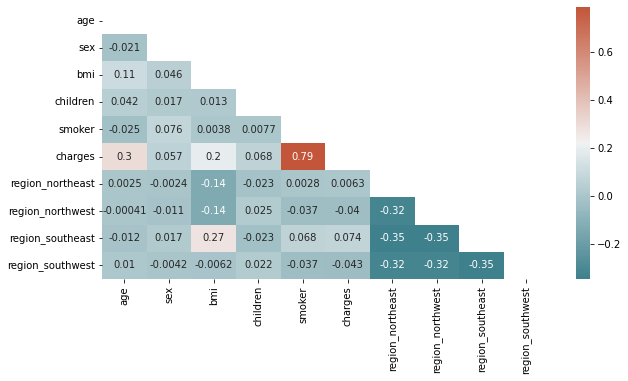

In [8]:
correlation = medical_cost_data.corr()
cmap = sns.diverging_palette(210, 20, as_cmap=True)
mask = np.triu(np.ones_like(correlation,dtype = bool))
plt.figure(figsize = (10,5))
ax = sns.heatmap(correlation, cmap = cmap, annot = True, mask = mask)
plt.show()

Only "smoker" feature is highly correlated with target variable.<br>I am a little bit surprised, because I thought, that age and body mass index have a higher correlation with the target.

## Distributions

In [9]:
sns.set_theme(style="ticks")

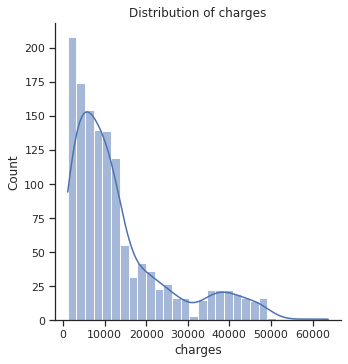

In [10]:
plot = sns.displot(x = "charges", data = medical_plot_data, kde = True)
plt.title("Distribution of charges")
plt.show()

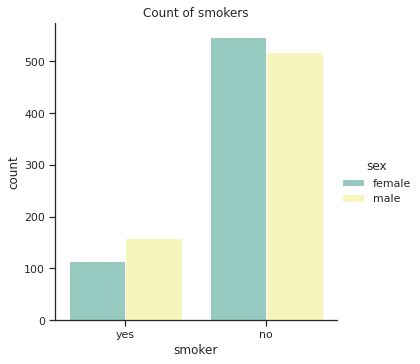

In [11]:
sns.catplot(x="smoker", hue = "sex",kind="count",data= medical_plot_data, palette = "Set3")
plt.title("Count of smokers")
plt.show()

As we can see there are more non-smokers, and males smoke a little more often than females.

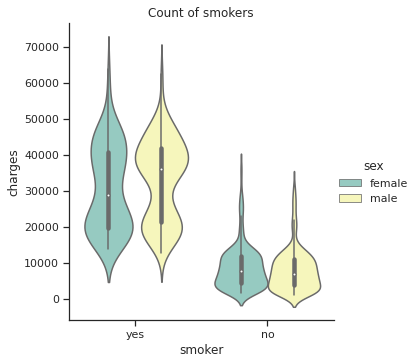

In [12]:
sns.catplot(x="smoker", y ="charges",hue = "sex",kind="violin",data= medical_plot_data,palette = "Set3")
plt.title("Count of smokers")
plt.show()

Smokers spend more money on treatment as 75th percentile of non-smokers is lower than 25th percentile of smokers.<br>
It is interesting that male smokers' median is higher than female smokers'.

## Age distribution

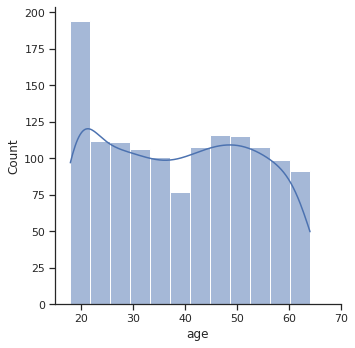

In [13]:
sns.displot(x = "age", data = medical_plot_data, kde = True)
plt.xlim(15,70)
plt.show()

Apparently a lot of people under 23 have a medical insurance.

Let's create a new column with category, that depends on the age of patient.

In [14]:
def age_category(age):
    if age >= 18 and age <21:
        return "Teen"
    elif age < 40:
        return "Young Adult"
    elif age < 60:
        return "Middle Adult"
    else:
        return "Old"

In [15]:
medical_plot_data["age_category"] = medical_plot_data.age.apply(age_category)

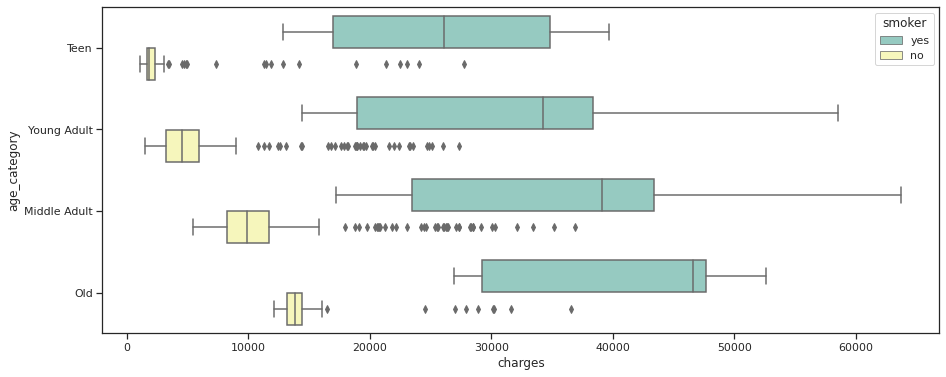

In [16]:
plt.figure(figsize=(15,6))
sns.boxplot(x="charges",y="age_category",hue = "smoker", data = medical_plot_data, palette = 'Set3')
plt.show()

The treatment charges gap between smokers and non-smokers in teen category is more significant that in other age groups.

## BMI distribution

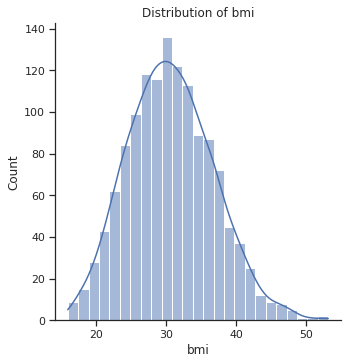

In [17]:
sns.displot(x = "bmi", data = medical_plot_data, kde = True)
plt.title("Distribution of bmi")
plt.show()

The "bmi" parameter is normaly distributed with mean = 30. This value is an obese-indicator.

Let's create a new column with category, that depends on the bmi of patient.

In [18]:
def bmi_category(bmi):
    if bmi<18.5:
        return "Underweight"
    elif bmi < 25:
        return "Normal"
    elif bmi < 30:
        return "Overweight"
    elif bmi < 35:
        return "Obese"
    else:
        return "Extremely Obese"

In [19]:
medical_plot_data["bmi_category"] = medical_plot_data.bmi.apply(bmi_category)
medical_plot_data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,Teen,Overweight
1,18,male,33.770,1,no,southeast,1725.55230,Teen,Obese
2,28,male,33.000,3,no,southeast,4449.46200,Young Adult,Obese
3,33,male,22.705,0,no,northwest,21984.47061,Young Adult,Normal
4,32,male,28.880,0,no,northwest,3866.85520,Young Adult,Overweight


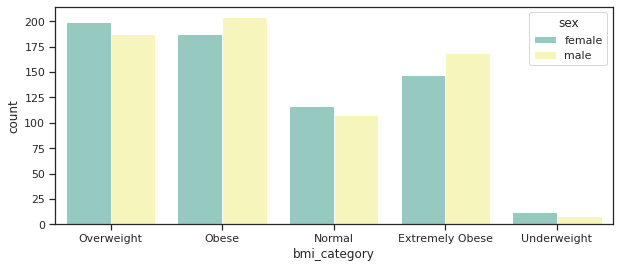

In [20]:
plt.figure(figsize=(10,4))
sns.countplot(x="bmi_category", hue = "sex", data = medical_plot_data, palette = 'Set3')
plt.show()

As we can see the male-female ratio in all categories is almost equal.

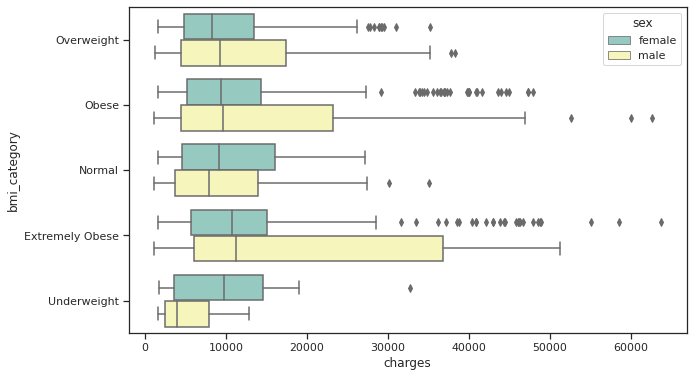

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x="charges",y="bmi_category", hue = "sex", data = medical_plot_data, palette = 'Set3')
plt.show()

Normal, Overweight and Obese people spend quite similar amount of money for the treatment.<br>
Interesting fact, that Underweight females spend more money than Underweight males.<br><br>
I reckon, the reason is that a lot of females belong to Underweight category because of eating disorders,<br>whereas in Underweight male group it's mostly a genetic  factor.

## Dataset Standardization

In [22]:
X = medical_cost_data.drop("charges", axis = 1)
y = medical_cost_data["charges"].values

X_standart = ((X - np.mean(X))/ np.std(X))
X_stand_shuffled = X_standart.sample(frac = 1)
y_shuffled = y[X_stand_shuffled.index]


X_train, X_test = np.split(X_stand_shuffled, [int(0.8 * len(y_shuffled))])
y_train, y_test = np.split(y_shuffled, [int(0.8 * len(y_shuffled))])

In [23]:
X_train.head()

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
337,1.622887,0.989591,-0.510736,-0.078767,-0.507463,-0.565267,1.765481,-0.611324,-0.566418
749,-0.797954,0.989591,0.034712,-0.908614,-0.507463,-0.565267,1.765481,-0.611324,-0.566418
1176,0.910875,-1.010519,-1.071768,-0.078767,1.970587,-0.565267,1.765481,-0.611324,-0.566418
936,0.341265,0.989591,-0.152298,0.751079,-0.507463,1.769076,-0.566418,-0.611324,-0.566418
17,-1.153959,0.989591,-1.118520,-0.908614,-0.507463,1.769076,-0.566418,-0.611324,-0.566418


## My Linear Regression Model

In [24]:
my_linear = MyLinearRegression(learning_rate = 0.1, max_iterations = 100, regularization_term = 0.1)
my_linear_history = my_linear.fit(X_train,y_train, report_periodicity = 20)


0/100: Loss -> 158094203.448
20/100: Loss -> 20298492.902
40/100: Loss -> 18009859.09
60/100: Loss -> 17966903.944
80/100: Loss -> 17965953.014
100/100: Loss -> 17965926.549

In [25]:
y_test_pred = my_linear.predict(X_test)

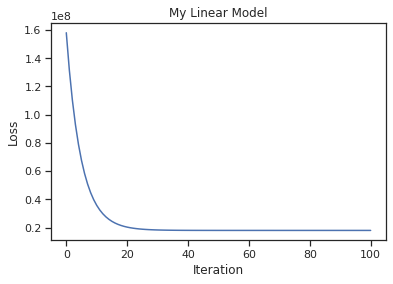

In [26]:
figure = sns.lineplot(x = my_linear_history.keys(), y = my_linear_history.values())
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("My Linear Model")
plt.show(figure)

In [27]:
mse(y_test,y_test_pred)

38966704.56265609

## Sklearn Linear Model

In [41]:
sklearn_linear_model = LinearRegression().fit(X_train, y_train)
sklearn_linear_pred = sklearn_linear_model.predict(X_test)

In [42]:
mse(sklearn_linear_pred, y_test)

38967588.21456186

In [108]:
random_forest = RandomForestRegressor(n_estimators = 10)
random_forest.fit(X_train, y_train)
random_forest_pred = random_forest.predict(X_test) 

In [109]:
mse(random_forest_pred, y_test)

30757266.754952196